# **ENVIRONMENT SETUP**

## **Connect to Google Drive**
  Mount Google Drive to access the dataset stored in Drive.

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import Required Libraries**

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import logging
from google.colab import files

# **DATA LOADING AND PREPROCESSING**

In [38]:
# Disable TensorFlow warnings
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [39]:
def load_and_split_data(dataset_path, image_size=(128, 128), test_size=0.2):
    print(f"Loading data from: {dataset_path}")

    data = []
    labels = []
    classes = []

    # Iterate through subdirectories
    for idx, class_dir in enumerate(sorted(os.listdir(dataset_path))):
        class_path = os.path.join(dataset_path, class_dir)
        if os.path.isdir(class_path):
            classes.append(class_dir)
            print(f"Loading class {idx}: {class_dir}")

            # Count images in this folder
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            total_images = len(image_files)
            print(f"  - {total_images} images found")

            # Load and preprocess images
            for i, img_file in enumerate(image_files):
                if i % 20 == 0:
                    print(f"  - Processing: {i}/{total_images}", end="\r")

                img_path = os.path.join(class_path, img_file)
                try:
                    # Load and resize image
                    img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    data.append(img_array)
                    labels.append(idx)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

            print(f"  - Processing completed: {total_images}/{total_images}")

    # Convert to numpy arrays and normalize pixel values to [0,1]
    data = np.array(data, dtype='float32') / 255.0
    labels = np.array(labels)

    print(f"\nTotal images loaded: {len(data)}")
    print(f"Classes: {classes}")

    # Split data into training and testing sets
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labels, test_size=test_size, random_state=42, stratify=labels
    )

    print(f"Training set: {train_data.shape}, {train_labels.shape}")
    print(f"Testing set: {test_data.shape}, {test_labels.shape}")

    return train_data, train_labels, test_data, test_labels, classes


# **FEATURE EXTRACTION AND MODEL ARCHITECTURE**

In [40]:
def extract_features(model, data, batch_size=32):
    print("Extracting features...")
    features = model.predict(data, batch_size=batch_size, verbose=1)
    return features

In [41]:
def train_model(train_features, train_labels, val_features, val_labels, num_classes, model_save_path):
    """Build and train the classification model."""
    print("Building and training the model...")

    # Define input shape
    input_shape = (train_features.shape[1],)

    # Build the neural network
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.5),  # Prevent overfitting
        Dense(64, activation='relu'),
        Dropout(0.3),  # Prevent overfitting
        Dense(num_classes, activation='softmax')  # Multi-class classification
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks for training
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    checkpoint = ModelCheckpoint(
        model_save_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    # Train the model
    history = model.fit(
        train_features, train_labels,
        validation_data=(val_features, val_labels),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping, checkpoint]
    )

    # Display model architecture
    model.summary()

    return model, history

# **MODEL EVALUATION AND VISUALIZATION**

## **Training Results Visualization**

In [42]:
"""
Plot training and validation accuracy/loss curves to visualize
how well the model learned and whether it's overfitting.
"""

def plot_training_results(history):
    """Display training and validation accuracy/loss graphs."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## **Model Evaluation Function**

In [43]:
def evaluate_model(model, test_features, test_labels, classes):
    """Evaluate the model on the test set."""
    print("\nEvaluating model on test set:")

    # Calculate accuracy and loss
    loss, accuracy = model.evaluate(test_features, test_labels, verbose=0)
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Test loss: {loss:.4f}")

    # Make predictions
    predictions = model.predict(test_features)
    predicted_classes = np.argmax(predictions, axis=1)

    # Show sample predictions
    print("\nSample predictions:")
    for i in range(min(5, len(test_labels))):
        true_class = classes[test_labels[i]]
        pred_class = classes[predicted_classes[i]]
        confidence = predictions[i][predicted_classes[i]] * 100

        print(f"Image {i+1}:")
        print(f"  - True class: {true_class}")
        print(f"  - Prediction: {pred_class} (confidence: {confidence:.2f}%)")
        print(f"  - {'✓' if test_labels[i] == predicted_classes[i] else '✗'}")

## **Single Image Testing Function**

In [44]:
def test_on_single_image(model_path, feature_extractor_path, image_path, class_names, image_size=(128, 128)):
    """Test the model on a single image and display results."""
    try:
        # Load models
        model = load_model(model_path)
        feature_extractor = load_model(feature_extractor_path)

        # Load and preprocess image
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Extract features
        features = feature_extractor.predict(img_array, verbose=0)
        features = features.reshape(1, -1)  # Flatten features

        # Make prediction
        prediction = model.predict(features, verbose=0)
        predicted_class_index = np.argmax(prediction[0])
        predicted_class = class_names[predicted_class_index]
        confidence = prediction[0][predicted_class_index] * 100

        # Display results
        img = plt.imread(image_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=14)
        plt.axis('off')
        plt.show()

        print(f"Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")

        # Show all class probabilities
        print("\nAll class probabilities:")
        for i, (class_name, prob) in enumerate(zip(class_names, prediction[0])):
            print(f"{class_name}: {prob*100:.2f}%")

        return predicted_class, confidence

    except Exception as e:
        print(f"Error testing image: {e}")
        return None, 0

# **MAIN TRAINING PIPELINE**

## **Main Training Function**

Main function that orchestrates the entire training process:
1. Load and split data
2. Create feature extractor (VGG16)
3. Extract features from images
4. Train classification model
5. Evaluate results
6. Save models

In [45]:
def main():
    # Define paths and parameters (Google Colab environment)
    output_dir = "/content/models"
    dataset_path = "/content/drive/MyDrive/newData"

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Define file paths
    model_save_path = os.path.join(output_dir, "face_recognition_model.h5")
    extractor_save_path = os.path.join(output_dir, "feature_extractor.h5")
    class_names_path = os.path.join(output_dir, "class_names.txt")

    # Set image size
    image_size = (128, 128)

    # Load and split data
    train_data, train_labels, test_data, test_labels, classes = load_and_split_data(
        dataset_path, image_size=image_size, test_size=0.2
    )

    # Create feature extractor using pre-trained VGG16
    print("Creating VGG16 feature extractor...")
    feature_extractor = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
    feature_extractor.trainable = False  # Freeze pre-trained weights

    # Extract features from images
    train_features = extract_features(feature_extractor, train_data)
    test_features = extract_features(feature_extractor, test_data)

    # Flatten features for classification
    train_features = train_features.reshape(train_features.shape[0], -1)
    test_features = test_features.reshape(test_features.shape[0], -1)

    # Train the classification model
    model, history = train_model(
        train_features, train_labels,
        test_features, test_labels,
        len(classes), model_save_path
    )

    # Visualize training results
    plot_training_results(history)

    # Evaluate the model
    evaluate_model(model, test_features, test_labels, classes)

    # Save feature extractor
    print(f"Saving feature extractor to {extractor_save_path}")
    feature_extractor.save(extractor_save_path)

    # Save class names
    print(f"Saving class names to {class_names_path}")
    with open(class_names_path, 'w') as f:
        for class_name in classes:
            f.write(f"{class_name}\n")

    print("\nTraining completed!")
    print(f"Model saved to: {model_save_path}")
    print(f"Feature extractor saved to: {extractor_save_path}")
    print(f"Class names saved to: {class_names_path}")

    # Download files in Colab
    print("\nDownloading model files...")
    files.download(model_save_path)
    files.download(extractor_save_path)
    files.download(class_names_path)

    return model, feature_extractor, classes

## **Testing Function**

In [46]:
def test_example():
    # Define model paths
    model_path = "/content/models/face_recognition_model.h5"
    extractor_path = "/content/models/feature_extractor.h5"
    class_names_path = "/content/models/class_names.txt"

    # Load class names
    with open(class_names_path, 'r') as f:
        class_names = [line.strip() for line in f.readlines()]

    # Upload test image
    uploaded = files.upload()

    # Test on uploaded image
    for filename in uploaded.keys():
        test_on_single_image(
            model_path=model_path,
            feature_extractor_path=extractor_path,
            image_path=filename,
            class_names=class_names
        )

# **EXECUTION CONTROL**

What would you like to do?
1. Train the model
2. Test with an image
Enter your choice (1/2): 1
Loading data from: /content/drive/MyDrive/newData
Loading class 0: Rhandor
  - 130 images found
  - Processing completed: 130/130
Loading class 1: Sadik
  - 127 images found
  - Processing completed: 127/127
Loading class 2: Unknown
  - 107 images found
  - Processing completed: 107/107
Loading class 3: mustapha
  - 130 images found
  - Processing completed: 130/130

Total images loaded: 494
Classes: ['Rhandor', 'Sadik', 'Unknown', 'mustapha']
Training set: (395, 128, 128, 3), (395,)
Testing set: (99, 128, 128, 3), (99,)
Creating VGG16 feature extractor...
Extracting features...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step
Extracting features...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Building and training the model...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3154 - loss: 1.8068
Epoch 1: val_accuracy improved from -inf to 0.85859, saving model to /content/models/face_recognition_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.3180 - loss: 1.7907 - val_accuracy: 0.8586 - val_loss: 0.8646
Epoch 2/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5312 - loss: 1.1276
Epoch 2: val_accuracy improved from 0.85859 to 0.87879, saving model to /content/models/face_recognition_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5861 - loss: 0.9436 - val_accuracy: 0.8788 - val_loss: 0.6045
Epoch 3/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5625 - loss: 1.1336
Epoch 3: val_accuracy improved from 0.87879 to 0.88889, saving model to /content/models/face_recognition_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7050 - loss: 0.7431 - val_accuracy: 0.8889 - val_loss: 0.3889
Epoch 4/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8750 - loss: 0.5679
Epoch 4: val_accuracy did not improve from 0.88889
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8190 - loss: 0.5403 - val_accuracy: 0.8889 - val_loss: 0.3803
Epoch 5/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8750 - loss: 0.3129
Epoch 5: val_accuracy did not improve from 0.88889
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8878 - loss: 0.3401 - val_accuracy: 0.8889 - val_loss: 0.3122
Epoch 6/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9062 - loss: 0.2259
Epoch 6: val_accuracy improved from 0.88889 to 0.90909, saving model to /content/models/face_recognition_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8960 - loss: 0.2817 - val_accuracy: 0.9091 - val_loss: 0.3012
Epoch 7/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9375 - loss: 0.2480
Epoch 7: val_accuracy improved from 0.90909 to 0.91919, saving model to /content/models/face_recognition_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9370 - loss: 0.2407 - val_accuracy: 0.9192 - val_loss: 0.2762
Epoch 8/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8750 - loss: 0.2402
Epoch 8: val_accuracy improved from 0.91919 to 0.92929, saving model to /content/models/face_recognition_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9190 - loss: 0.2148 - val_accuracy: 0.9293 - val_loss: 0.2450
Epoch 9/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8750 - loss: 0.4332
Epoch 9: val_accuracy did not improve from 0.92929
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9434 - loss: 0.2073 - val_accuracy: 0.9293 - val_loss: 0.2347
Epoch 10/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9375 - loss: 0.1558
Epoch 10: val_accuracy improved from 0.92929 to 0.93939, saving model to /content/models/face_recognition_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9462 - loss: 0.1543 - val_accuracy: 0.9394 - val_loss: 0.1789
Epoch 11/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0620
Epoch 11: val_accuracy did not improve from 0.93939
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9604 - loss: 0.1259 - val_accuracy: 0.9293 - val_loss: 0.2157
Epoch 12/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0639
Epoch 12: val_accuracy improved from 0.93939 to 0.94949, saving model to /content/models/face_recognition_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9896 - loss: 0.0695 - val_accuracy: 0.9495 - val_loss: 0.2461
Epoch 13/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9062 - loss: 0.3483
Epoch 13: val_accuracy did not improve from 0.94949
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9450 - loss: 0.1624 - val_accuracy: 0.9495 - val_loss: 0.2142
Epoch 14/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9688 - loss: 0.1462
Epoch 14: val_accuracy did not improve from 0.94949
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9782 - loss: 0.0955 - val_accuracy: 0.9394 - val_loss: 0.2215
Epoch 15/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9062 - loss: 0.1271
Epoch 15: val_accuracy did not improve from 0.94949
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9552 - loss: 0.0783 - val_accuracy: 0.9192 - val_loss: 0.2416
Epoch 16/50
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0531
Epoch 16: val_accuracy did not improve 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,171,662 (12.10 MB)

 Trainable params: 1,057,220 (4.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,114,442 (8.07 MB)

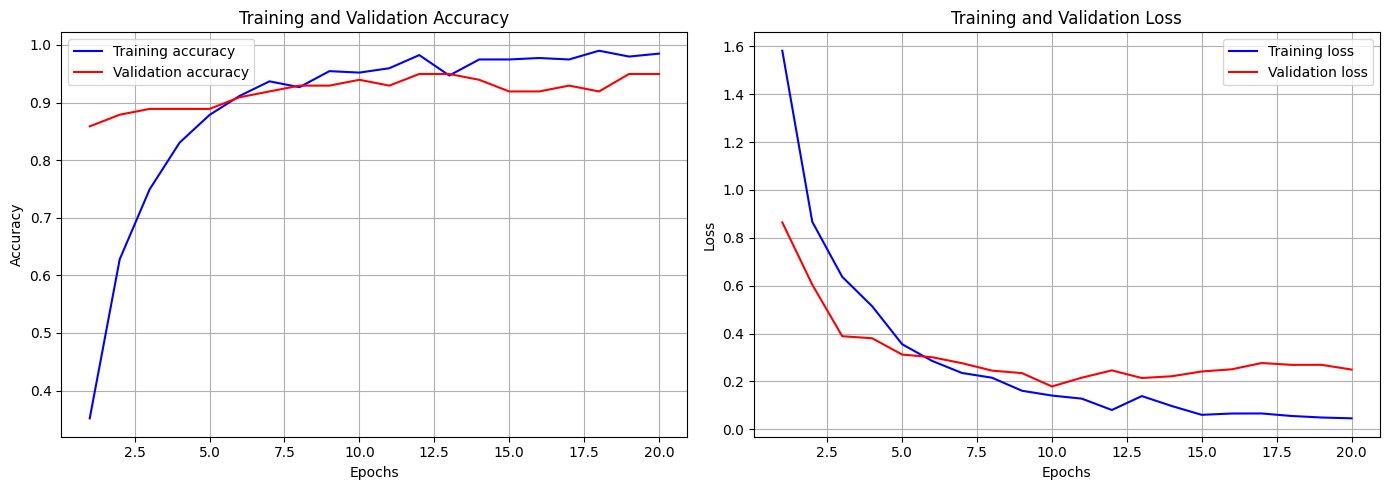


Evaluating model on test set:
Test accuracy: 0.9394
Test loss: 0.1789
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step



Sample predictions:
Image 1:
  - True class: Rhandor
  - Prediction: Rhandor (confidence: 98.94%)
  - ✓
Image 2:
  - True class: mustapha
  - Prediction: mustapha (confidence: 98.80%)
  - ✓
Image 3:
  - True class: Unknown
  - Prediction: Unknown (confidence: 99.68%)
  - ✓
Image 4:
  - True class: Sadik
  - Prediction: Sadik (confidence: 99.93%)
  - ✓
Image 5:
  - True class: Rhandor
  - Prediction: Rhandor (confidence: 99.50%)
  - ✓
Saving feature extractor to /content/models/feature_extractor.h5
Saving class names to /content/models/class_names.txt

Training completed!
Model saved to: /content/models/face_recognition_model.h5
Feature extractor saved to: /content/models/feature_extractor.h5
Class names saved to: /content/models/class_names.txt



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Do you want to test the model with an image? (y/n): y


Saving IMG-20250516-WA0136.jpg to IMG-20250516-WA0136.jpg


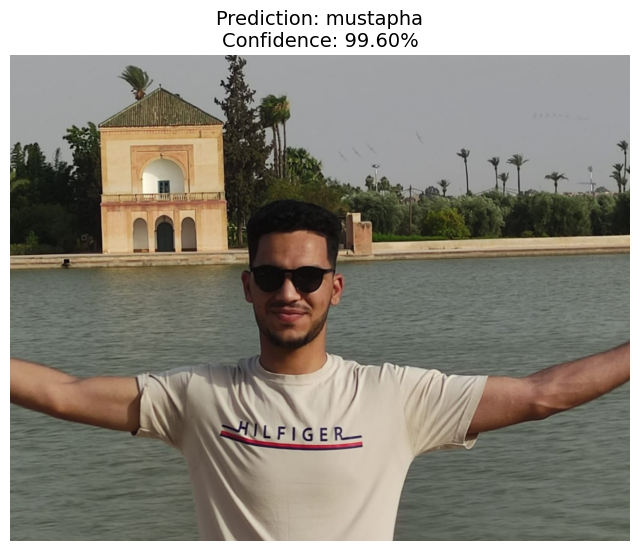

Predicted class: mustapha
Confidence: 99.60%

All class probabilities:
Rhandor: 0.16%
Sadik: 0.00%
Unknown: 0.23%
mustapha: 99.60%


In [47]:

if __name__ == "__main__":
    print("What would you like to do?")
    print("1. Train the model")
    print("2. Test with an image")

    choice = input("Enter your choice (1/2): ")

    if choice == "1":
        model, feature_extractor, classes = main()

        # Ask if user wants to test with an image
        test_img = input("Do you want to test the model with an image? (y/n): ")
        if test_img.lower() in ["y", "yes"]:
            test_example()
    elif choice == "2":
        test_example()
    else:
        print("Invalid choice!")


# **TENSORFLOW LITE CONVERSION**

## **TensorFlow Lite Conversion Functions**

In [48]:
def convert_h5_to_tflite(h5_model_path, output_dir=None):
    """Convert a single H5 model to TensorFlow Lite format."""
    print(f"Loading model from: {h5_model_path}")

    # Load the model
    model = tf.keras.models.load_model(h5_model_path)

    # Create TensorFlow Lite converter
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Convert the model
    print("Converting model to TFLite format...")
    tflite_model = converter.convert()
    print("Conversion completed!")

    # Create output directory
    if output_dir is None:
        output_dir = os.path.dirname(h5_model_path)
    os.makedirs(output_dir, exist_ok=True)

    # Save the TFLite model
    model_basename = os.path.basename(h5_model_path).replace('.h5', '')
    tflite_path = os.path.join(output_dir, f"{model_basename}.tflite")

    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)

    print(f"TFLite model saved to: {tflite_path}")
    return tflite_path

def convert_feature_extractor_and_model(model_path, feature_extractor_path, output_dir=None):
    """Convert both the classification model and feature extractor to TFLite."""
    if output_dir is None:
        output_dir = os.path.dirname(model_path)

    # Convert both models
    model_tflite_path = convert_h5_to_tflite(model_path, output_dir)
    extractor_tflite_path = convert_h5_to_tflite(feature_extractor_path, output_dir)

    return model_tflite_path, extractor_tflite_path

## **Colab-Specific Conversion Function**

In [49]:

def convert_colab_models():
    """Convert models in Google Colab environment with automatic download."""
    model_path = "/content/models/face_recognition_model.h5"
    extractor_path = "/content/models/feature_extractor.h5"
    output_dir = "/content/models"

    print(f"Converting models:")
    print(f"- Face recognition model: {model_path}")
    print(f"- Feature extractor: {extractor_path}")
    print(f"- Output directory: {output_dir}")

    model_tflite_path, extractor_tflite_path = convert_feature_extractor_and_model(
        model_path, extractor_path, output_dir
    )

    # Download converted files in Colab
    try:
        print("\nDownloading converted TFLite models...")
        files.download(model_tflite_path)
        files.download(extractor_tflite_path)
    except ImportError:
        print("\nFiles converted successfully. Find them at:")
        print(f"- {model_tflite_path}")
        print(f"- {extractor_tflite_path}")

    return model_tflite_path, extractor_tflite_path

## **TFLite Conversion Execution**

In [50]:
if __name__ == "__main__":
    # Check if running in Google Colab
    try:
        import google.colab
        print("Running in Google Colab environment. Using predefined paths...")
        convert_colab_models()
    except ImportError:
        print("Not running in Colab. Use command line arguments for conversion.")


Running in Google Colab environment. Using predefined paths...
Converting models:
- Face recognition model: /content/models/face_recognition_model.h5
- Feature extractor: /content/models/feature_extractor.h5
- Output directory: /content/models
Loading model from: /content/models/face_recognition_model.h5
Converting model to TFLite format...
Saved artifact at '/tmp/tmp1_np4ody'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 8192), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137413059516112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137413059511504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137413059516304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137413059518800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137413059515344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137413059515920: TensorSpec

Conversion completed!
TFLite model saved to: /content/models/face_recognition_model.tflite
Loading model from: /content/models/feature_extractor.h5
Converting model to TFLite format...
Saved artifact at '/tmp/tmp698d9zpr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 4, 4, 512), dtype=tf.float32, name=None)
Captures:
  137413057001616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137413056995280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137413056996048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137413056999120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137413056989328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137413057002384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137413056998928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137413057001232: TensorSpec(sh

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# =============================================================================
# END OF NOTEBOOK
# =============================================================================